<a href="https://colab.research.google.com/github/francji1/01RAD/blob/main/python/01RAD_Ex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01RAD Exercise 11

* Robust Regression - How to deal with Outliers and Leverages
* Very fast intro of Robust regression - M, MM, LTS, LWS


In [1]:

# Python equivalent imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


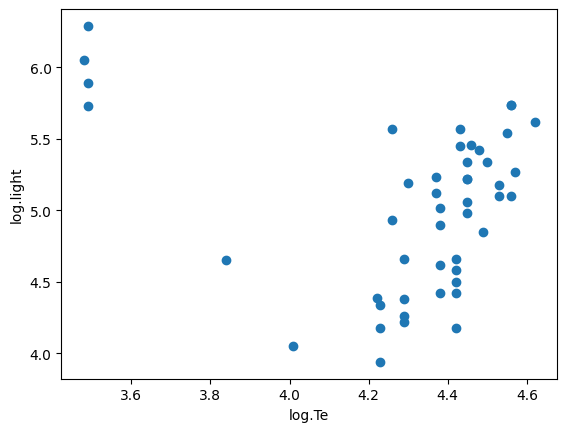

In [2]:
import matplotlib.pyplot as plt

# Load the dataset
dta = sm.datasets.get_rdataset("starsCYG", "robustbase", cache=True).data

plt.scatter(dta['log.Te'], dta['log.light'])
plt.xlabel('log.Te')
plt.ylabel('log.light')
# Set xlim and other properties as needed
plt.show()


In [3]:
import statsmodels.api as sm

# OLS
X = sm.add_constant(dta['log.Te'])  # Adding a constant for the intercept
OLS_stars = sm.OLS(dta['log.light'], X).fit()
print(OLS_stars.summary())

                            OLS Regression Results                            
Dep. Variable:              log.light   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.085
Date:                Tue, 12 Dec 2023   Prob (F-statistic):              0.156
Time:                        11:46:20   Log-Likelihood:                -38.804
No. Observations:                  47   AIC:                             81.61
Df Residuals:                      45   BIC:                             85.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7935      1.237      5.494      0.0

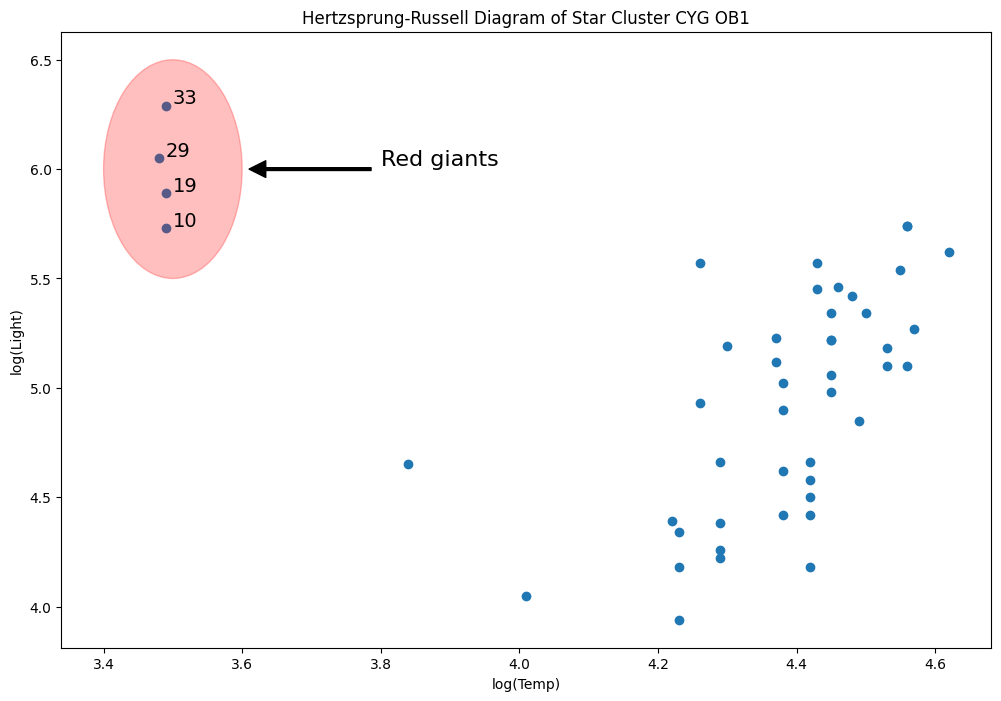

In [4]:
from matplotlib.patches import Ellipse

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(
    111,
    xlabel="log(Temp)",
    ylabel="log(Light)",
    title="Hertzsprung-Russell Diagram of Star Cluster CYG OB1",
)
ax.scatter(*dta.values.T)
# highlight outliers
e = Ellipse((3.5, 6), 0.2, 1, alpha=0.25, color="r")
ax.add_patch(e)
ax.annotate(
    "Red giants",
    xy=(3.6, 6),
    xytext=(3.8, 6),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
    horizontalalignment="left",
    verticalalignment="bottom",
    clip_on=True,  # clip to the axes bounding box
    fontsize=16,
)
# annotate these with their index
for i, row in dta.loc[dta["log.Te"] < 3.8].iterrows():
    ax.annotate(i, row, row + 0.01, fontsize=14)
xlim, ylim = ax.get_xlim(), ax.get_ylim()

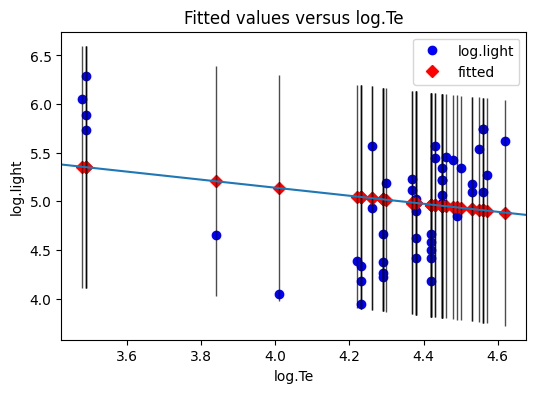

In [26]:
from statsmodels.graphics.api import abline_plot
from statsmodels.formula.api import ols, rlm
y = dta["log.light"]
X = sm.add_constant(dta["log.Te"], prepend=True)
ols_model = sm.OLS(y, X).fit()
abline_plot(model_results=ols_model, ax=ax)

https://github.com/jseabold/statsmodels-tutorial/blob/master/robust_models.ipynb

https://github.com/statsmodels/statsmodels/blob/main/examples/notebooks/robust_models_0.ipynb

In [27]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(OLS_stars)
summary_influence = influence.summary_frame()

# Extracting influence measures
out_index = summary_influence.index
print(out_index)


RangeIndex(start=0, stop=47, step=1)


In [6]:
# Hat values
# Hat values
hat_values = influence.hat_matrix_diag
hat_values_sorted = np.sort(hat_values)[::-1]  # Sorting in descending order
print(np.round(hat_values_sorted[:10], 4))  # Printing the top 10 values

[0.1983 0.1941 0.1941 0.1941 0.0781 0.046  0.0444 0.0387 0.0373 0.0373]


In [7]:
# Number of observations with high leverage
n = len(dta)
r = 2  # Number of regression coefficients (including the intercept)
high_leverage = sum(hat_values > 3 * r / n)
print(high_leverage)
print(dta[hat_values > 3 * r / n])


4
    log.Te  log.light
10    3.49       5.73
19    3.49       5.89
29    3.48       6.05
33    3.49       6.29


In [8]:
# DFFITS
dffits = influence.dffits[0]
print(round(dffits, 4).sort_values(ascending=False).head(10))

33    0.9353
29    0.6907
19    0.5226
10    0.3651
1     0.2998
3     0.2998
35    0.2956
44    0.2196
39    0.1748
5     0.1524
dtype: float64


In [9]:
# Observations with high influence
high_influence = dta[np.abs(dffits) > 3 * np.sqrt(r / (n - r))]
print(high_influence)


    log.Te  log.light
29    3.48       6.05
33    3.49       6.29


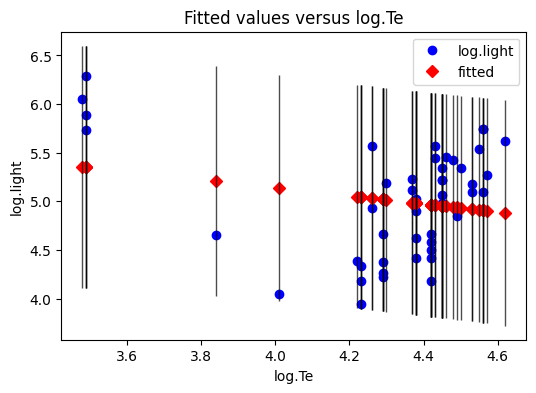

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
sm.graphics.plot_fit(OLS_stars, 'log.Te', ax=ax)
plt.show()


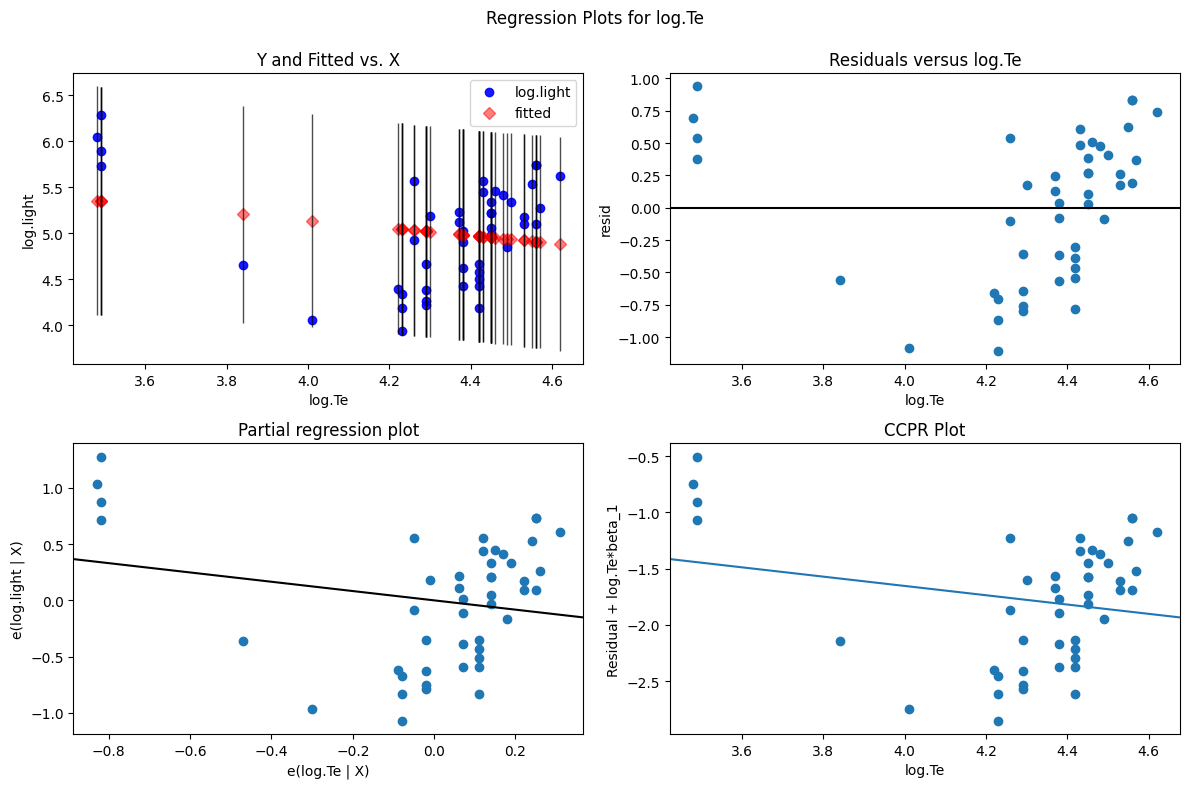

In [11]:
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(OLS_stars, 'log.Te', fig=fig)
plt.show()

In [12]:
# Robust regression using statsmodels' RLM

# Huber's T
huber_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.HuberT())
M_huber_stars = huber_model.fit()

# Hampel
hampel_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.Hampel())
M_hampel_stars = hampel_model.fit()

# Bisquare (Tukey's biweight)
bisquare_model = sm.RLM(dta['log.light'], X, M=sm.robust.norms.TukeyBiweight())
M_bisquare_stars = bisquare_model.fit()

# For MM estimators, statsmodels currently does not have a direct equivalent to R's rlm method='MM'

rlm_TrimmedMean = sm.RLM(dta['log.light'], X, sm.robust.norms.TrimmedMean(0.5))
M_TrimmedMean_stars = rlm_TrimmedMean.fit()

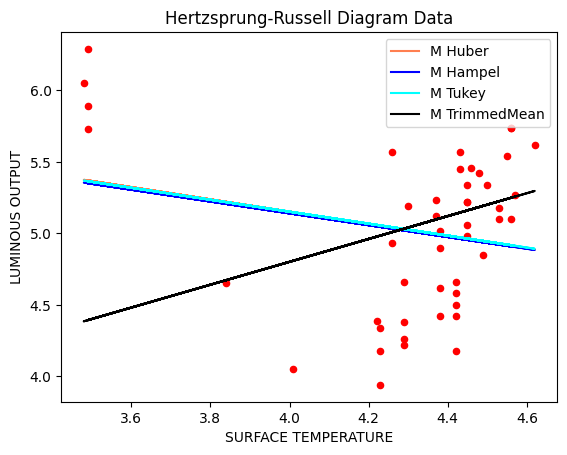

In [13]:
# Plotting the Hertzsprung-Russell Diagram Data with regression lines
plt.scatter(dta['log.Te'], dta['log.light'], color='red', s=20)
plt.xlabel('SURFACE TEMPERATURE')
plt.ylabel('LUMINOUS OUTPUT')
plt.title('Hertzsprung-Russell Diagram Data')

# Adding regression lines
plt.plot(dta['log.Te'], M_huber_stars.fittedvalues, color='coral', label='M Huber')
plt.plot(dta['log.Te'], M_hampel_stars.fittedvalues, color='blue', label='M Hampel')
plt.plot(dta['log.Te'], M_bisquare_stars.fittedvalues, color='cyan', label='M Tukey')
plt.plot(dta['log.Te'], M_TrimmedMean_stars.fittedvalues, color='black', label='M TrimmedMean')


plt.legend()
plt.show()


In [33]:
!pip install rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [34]:
%%R
install.packages('robustbase')
library(robustbase)
data(starsCYG)
? starsCYG

(as ‘lib’ is unspecified)







	‘/tmp/RtmpLB35EC/downloaded_packages’

  lazy-load database '/usr/local/lib/R/site-library/robustbase/help/robustbase.rdb' is corrupt





RRuntimeError: ignored

In [ ]:
%%R
data(starsCYG)
? starsCY

In [ ]:
%%R
library(MASS)
# Robust regression by M-estimator
# rlm(formula, data,..., method = c("M","MM"))
# M estimate with diferent types of weight functions psi (derivative of rho)
# MM estimate - S estimate + M estimate

# Definitions of Psi-Functions Available in Robustbase
# See enclosed pdf file

# Huber family of functions using tuning parameter k = 1.345.
names(.Mpsi.tuning.defaults)
plot(huberPsi, ylim=c(-1.4, 5), leg.loc="topright",cex=0.8)

# Bisquare family functions using tuning parameter k = 4.685
x = seq(-5,5,by=0.01)
source(system.file("xtraR/plot-psiFun.R", package = "robustbase", mustWork=TRUE))
p.psiFun( x, "biweight", par = 4.685)

# GGW (Generalized Gauss-Weight function )family of functions
# using tuning parameters a = 1.387, b = 1.5 and c = 1.063.
p.psiFun(x, "GGW", par = c(-.5, 1, .95, NA))


# rlm from MASS
# Summary plot for starsCYG
M_huber_stars    <- rlm(log.light ~ log.Te, method="M", psi = psi.huber)    # Huber
M_hampel_stars   <- rlm(log.light ~ log.Te, method="M", psi = psi.hampel)   # Hampel
M_bisquare_stars <- rlm(log.light ~ log.Te, method="M", psi = psi.bisquare) # Tukey
MM_bisquare_stars<- rlm(log.light ~ log.Te, method="MM",psi = psi.bisquare) # Tukey
MM_ggw_stars     <- rlm(log.light ~ log.Te, method="MM",psi = psi.ggw)      # GGW
plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(M_huber_stars, col="coral",lwd=1.8)
abline(M_hampel_stars, col="blue")
abline(M_bisquare_stars, col="cyan")
abline(MM_bisquare_stars, col="firebrick", lwd = 2)
abline(MM_ggw_stars, col="green")
legend("bottomleft",cex=0.7,legend = c("M Huber","M Hampel","M Tukey","MM Tukey","MM GGW"),
       lty = c(1,1,1,1,1),col = c("coral","blue","cyan","firebrick","green"))




In [ ]:
%%R
coef(summary(MM_ggw_stars))


In [ ]:
%%R
# alternative to MM from rlm is lmrob from robustbase package
# lmrob computes fast MM-type estimator
# ? mlrob - MM-type Estimators for Linear Regression
# ? nlrob - Robust Fitting of Nonlinear Regression Models

MM_stars2 <- lmrob(log.light ~ log.Te, init = "S")
MM_stars2$coefficients
summary(MM_stars2)
coef(summary(MM_stars2))

In [ ]:
%%R
# Robust regression by LMS-estimator
LMS_stars  <- lmsreg(log.light ~ log.Te)
LMS_stars


# Robust regression by LTS-estimator
# two possibilities - ltsreg from MASS (lqs(formula, data, ..., method = c("lts")))
#                   - ltsReg from robustbase
?ltsreg
?ltsReg

LTS_stars  <- ltsreg(log.light ~ log.Te)

LTS_stars  <- ltsReg(log.light ~ log.Te, alpha=0.9)
# when stop the algorithm?
LTS_stars  <- ltsReg(log.light ~ log.Te, alpha=0.5, nsamp="best")
LTS_stars  <- ltsReg(log.light ~ log.Te, alpha=0.5, nsamp="best")
LTS_stars  <- ltsReg(log.light ~ log.Te, alpha=0.5, nsamp="exact")



# Summary plot for starsCYG
OLS_stars  <- lm(log.light ~ log.Te)
MM_stars   <- rlm(log.light ~ log.Te,method="MM")
LTS_stars  <- ltsreg(log.light ~ log.Te)
LTS2_stars <- ltsReg(log.light ~ log.Te, alpha=0.9)
LMS_stars  <- lmsreg(log.light ~ log.Te)
plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(OLS_stars, col="black")

abline(MM_stars, col="blue")
abline(LTS_stars, col="red")
abline(LTS2_stars, col="darkred")
abline(LMS_stars, col="green")
legend("bottomleft",cex=0.7,legend = c("OLS","MM","LTS, h=0.5","LTS h=0.9","LMS"),
         lty = c(1,1,1,1,1),col = c("black","blue","red","darkred","green"))

In [ ]:
%%R
#GM-estimation
# MASS: rlm() with method=''M'' (Huber, Tukey, Hampel)
#               Choice for the scale estimator: MAD, Huber Proposal 2
#S-estimation
# robust: lmRob with estim=''Initial''
# robustbase: lmrob.S
#MM-estimation
# MASS: rlm() with method=''MM''
# robust: lmRob (with estim='''Final'', default)
# robustbase: lmrob()


# Problems with general position
data(exAM)
? exAM
summary(exAM)

#Because the points are not in general position, both LMS and LTS typically fail
summary(lm1   <- lm(y ~ x, data=exAM))
summary(rlm0  <- rlm(y ~ x, data=exAM,method="MM"))
summary(rlm1  <- ltsReg(y ~ x, data=exAM))
summary(rlm1b <- ltsReg(y ~ x, alpha = 0.9,data=exAM))
summary(rlm2  <- lmsreg(y ~ x, data=exAM))


plot(exAM,main="Antille and May artificial data set")
abline(lm1, col="black")
abline(rlm0, col="blue")
abline(rlm1, col="red")
abline(rlm1b, col="darkred")
abline(rlm2, col="green")
legend("topright",cex=0.7,legend = c("OLS","MM","LTS, h=0.5","LTS h=0.9","LMS"),
       lty = c(1,1,1,1,1),col = c("black","blue","red","darkred","green"))


In [ ]:
%%R
library(tidyverse)
# THE PROBLEM IS HOW LARGE h (alpha) WE SHOULD SELECT FOR LTS
# for example in Stars data - nearly now change
# How trimmed parameter h (alpha) change the estimation?
LTS_stars09 <- ltsReg(log.light ~ log.Te, alpha=0.9)
LTS_stars08 <- ltsReg(log.light ~ log.Te, alpha=0.8,nsamp="exact",adjust=F,mcd = F)
LTS_stars07 <- ltsReg(log.light ~ log.Te, alpha=0.7)
LTS_stars06 <- ltsReg(log.light ~ log.Te, alpha=0.6)
LTS_stars05 <- ltsReg(log.light ~ log.Te, alpha=0.5,nsamp="exact",adjust=F,mcd = F)
plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(LTS_stars09, col="black", lwd = 2)
abline(LTS_stars08, col="blue", lwd = 7)
abline(LTS_stars07, col="red", lwd = 5)
abline(LTS_stars06, col="darkred", lwd = 3)
abline(LTS_stars05, col="green", lwd = 1)
legend("bottomleft",cex=0.7,legend = c("LTS h=0.9","LTS h=0.8","LTS h=0.7","LTS h=0.6","LTS h=0.5"),
       lty = c(1,1,1,1,1),col = c("black","blue","red","darkred","green"))

# Ups, why does it have same number of DF?
summary(LTS_stars05)
summary(LTS_stars08)

# Let's check outputs
LTS_stars05$quan
LTS_stars08$quan

LTS_stars05$crit
LTS_stars08$crit

# But coefficents are same :(
LTS_stars05$coefficients
LTS_stars08$coefficients

# h points with smallest resids
LTS_stars05$best
LTS_stars08$best

# Apply ordinary LS to h best (selected) points
LTS_stars05OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars05$best,])
LTS_stars06OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars06$best,])
LTS_stars07OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars07$best,])
LTS_stars08OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars08$best,])
LTS_stars09OLS <- lm(log.light ~ log.Te, data=starsCYG[LTS_stars09$best,])

# commpare
summary(LTS_stars05OLS)
summary(LTS_stars08OLS)

plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(LTS_stars09OLS, col="black", lwd = 2)
abline(LTS_stars08OLS, col="blue", lwd = 2)
abline(LTS_stars07OLS, col="red", lwd = 2)
abline(LTS_stars06OLS, col="darkred", lwd = 2)
abline(LTS_stars05OLS, col="green", lwd = 2)
legend("bottomleft",cex=0.7,legend = c("LTS h=0.9","LTS h=0.8","LTS h=0.7","LTS h=0.6","LTS h=0.5"),
       lty = c(1,1,1,1,1),col = c("black","blue","red","darkred","green"))




ggplot(data=starsCYG, aes(log.Te, log.light)) +                    # use starsCYGdata frame
  geom_point() +
  geom_smooth(method="lm", aes(colour="OLS"), se=F) +
  geom_smooth(method="rlm", aes(colour="M"), se=T) +
  stat_smooth(method=function(formula,data,weights=weight) rlm(formula,
                                                               data,
                                                               weights=weight,
                                                               method="MM",
                                                               psi=psi.bisquare),
              fullrange=TRUE,aes(colour="MM bisquare"))+
  labs(colour=NULL)


In [ ]:
%%R
LWS <- function(y, x, w, niter){

    n <- nrow(x)
    p <- ncol(x)

   rWr_LWS=Inf;
   # iterations = rep(0,times=n);
   # Outer Cycle
   for(i in 1:niter) {
   # Performing one iteration in the outer cycle
   #    [b_OneIter,S_OneIter,rWr_OneIter,perm_OneIter,iterations_OneIter]=OneIter(X,Z,Y,w);
   OneIter = LWS_OneIter(y,x,w)

    if (rWr_LWS > OneIter$rWr){
    b_LWS      =  OneIter$b
    rWr_LWS    =  OneIter$rWr
    perm_LWS   =  OneIter$perm
    }
   }

    result <- list(beta=b_LWS, resid = rWr_LWS, rank=perm_LWS)
    return(result)
}

LWS_OneIter = function(Y, X, w){

    n <- nrow(X)
    p <- ncol(X)
    W <- diag(w);
    tau         <- 0.00001;
    rWr_OneIter <- Inf;
    b_OneIter   <- matrix( rep(0,times=p),p,1);

    # Select the initial values
    index  = sample(n)
    SX     = X[(index[1:p+2]),]
    SY     = Y[index[1:p+2]]
    while(kappa(SX) > 1e9 ){
        index  = sample(n)
        SX     = X[(index[1:(p+5)]),]
        SY     = Y[index[1:(p+5)]]
    }
    #print(kappa(SX))
    b      = OLS_qr(SY,SX)

    # Run the inner cycle
    while (sum(abs(b_OneIter - b) < tau) != p){
          #  rWr_OneIter > rWr && sum(abs(b_OneIter - b) < tau) ~= p;
          b_OneIter     = b

          r      = (Y-X%*%b)^2
          rI     = order(r)
          sX     = X[rI,]
          sY     = Y[rI,]

          swX    = (sqrt(w)*sX)[which(w != 0),]
          swY    = (sqrt(w)*sY)[which(w != 0)]
          b      = OLS_qr(swY,swX)
    }
    b_OneIter      = b
    r_OneIter      = (Y-X%*%b_OneIter)^2
    perm_OneIter   = order(r_OneIter)
    rWr_OneIter    = (r_OneIter[perm_OneIter]^2)%*%w
    # S      = t((sY-sX%*%b)^2)%*%w
    result_OneIter <- list(b=b_OneIter, rWr = rWr_OneIter, perm=perm_OneIter)
    return(result_OneIter)
}


OLS_qr = function(y, x, tol=1.e-07 ){
    qr_x <- qr(x, tol=tol, LAPACK=TRUE)
    b<-qr.coef(qr_x, y)
    return(b)
}

OLS_lm <- function (y, x){
    b<-coef(lm(y ~ x - 1))
    return(b)
}

OLS_def <- function (y, x) {
    b <- as.vector((solve(t(x)%*%x))%*%(t(x)%*%y))
    return(b)
}


Weights1 <- function(n){
    # Generating weights
    # h      - number of trimmed observations (observations with zero weights)
    # g      - number of observations with weights equal to 1
    # h-g-1  - number of observations with rapidly decreasing weights
h <- ceiling(0.9*n)
g <- ceiling(0.8*n)
w <- rep(0,times=n)
w[1:g] <- 1
w[g:h] <- seq(1,0,length=h-g+1)
return(w)
}


In [24]:
LWS <- function(y, x, w, niter){

    n <- nrow(x)
    p <- ncol(x)

   rWr_LWS=Inf;
   # iterations = rep(0,times=n);
   # Outer Cycle
   for(i in 1:niter) {
   # Performing one iteration in the outer cycle
   #    [b_OneIter,S_OneIter,rWr_OneIter,perm_OneIter,iterations_OneIter]=OneIter(X,Z,Y,w);
   OneIter = LWS_OneIter(y,x,w)

    if (rWr_LWS > OneIter$rWr){
    b_LWS      =  OneIter$b
    rWr_LWS    =  OneIter$rWr
    perm_LWS   =  OneIter$perm
    }
   }

    result <- list(beta=b_LWS, resid = rWr_LWS, rank=perm_LWS)
    return(result)
}

LWS_OneIter = function(Y, X, w){

    n <- nrow(X)
    p <- ncol(X)
    W <- diag(w);
    tau         <- 0.00001;
    rWr_OneIter <- Inf;
    b_OneIter   <- matrix( rep(0,times=p),p,1);

    # Select the initial values
    index  = sample(n)
    SX     = X[(index[1:p+2]),]
    SY     = Y[index[1:p+2]]
    while(kappa(SX) > 1e9 ){
        index  = sample(n)
        SX     = X[(index[1:(p+5)]),]
        SY     = Y[index[1:(p+5)]]
    }
    #print(kappa(SX))
    b      = OLS_qr(SY,SX)

    # Run the inner cycle
    while (sum(abs(b_OneIter - b) < tau) != p){
          #  rWr_OneIter > rWr && sum(abs(b_OneIter - b) < tau) ~= p;
          b_OneIter     = b

          r      = (Y-X%*%b)^2
          rI     = order(r)
          sX     = X[rI,]
          sY     = Y[rI,]

          swX    = (sqrt(w)*sX)[which(w != 0),]
          swY    = (sqrt(w)*sY)[which(w != 0)]
          b      = OLS_qr(swY,swX)
    }
    b_OneIter      = b
    r_OneIter      = (Y-X%*%b_OneIter)^2
    perm_OneIter   = order(r_OneIter)
    rWr_OneIter    = (r_OneIter[perm_OneIter]^2)%*%w
    # S      = t((sY-sX%*%b)^2)%*%w
    result_OneIter <- list(b=b_OneIter, rWr = rWr_OneIter, perm=perm_OneIter)
    return(result_OneIter)
}


OLS_qr = function(y, x, tol=1.e-07 ){
    qr_x <- qr(x, tol=tol, LAPACK=TRUE)
    b<-qr.coef(qr_x, y)
    return(b)
}

OLS_lm <- function (y, x){
    b<-coef(lm(y ~ x - 1))
    return(b)
}

OLS_def <- function (y, x) {
    b <- as.vector((solve(t(x)%*%x))%*%(t(x)%*%y))
    return(b)
}


Weights1 <- function(n){
    # Generating weights
    # h      - number of trimmed observations (observations with zero weights)
    # g      - number of observations with weights equal to 1
    # h-g-1  - number of observations with rapidly decreasing weights
h <- ceiling(0.9*n)
g <- ceiling(0.8*n)
w <- rep(0,times=n)
w[1:g] <- 1
w[g:h] <- seq(1,0,length=h-g+1)
return(w)
}


SyntaxError: ignored

In [ ]:
%%R
# Nagenerujeme si data
n=100
p=3
beta0 <- matrix(c(2,3,-4),p,1)

set.seed(123)
X1 <- rep(1,times=n)
X2 <- rnorm(n,10,2)
X3 <- rexp(n,1/5)
X  <- cbind(X1, X2, X3)
e  <- rnorm(n,0,1)
Y  <- X%*%beta0 + e

# Vytvorime 5% outlieru
Yoi    = sample(n)[1:ceiling(n/20)]
Y[Yoi] = 5*Y[Yoi]

# Vytvorime 5% Leverage pointu
Xoi     = sample(n)[1:ceiling(n/20)]
X[Xoi,2:p]  = 0.2*X[Xoi,2:p]



w = Weights1(n)
OLS_qr(Y,X)
LWS(Y,X,w,100)$beta
summary(ltsReg(Y ~ X2+X3, alpha=0.9))$coeff


#Use Hertzsprung-Russell Diagram Data of Star Cluster CYG OB1
? starsCYG
summary(starsCYG)
attach(starsCYG)

w_star       <- Weights1(nrow(starsCYG))
YY = as.matrix(log.light)
XX = cbind(rep(1,times=nrow(YY)), log.Te)
LWS_stars_lm <- LWS(YY, XX, w_star, 1000)
LTS_stars    <- ltsReg(log.light ~ log.Te, alpha=0.9)
OLS_stars    <- lm(log.light ~ log.Te)

plot(starsCYG,main="Hertzsprung-Russell Diagram Data",xlab="SURFICE TEMPERATURE", ylab="LUMINIOUS OUTPUT")
abline(OLS_stars, col="black")
abline(LWS_stars_lm$beta, col="blueviolet")
abline(LTS_stars, col="red")
legend("bottomleft",cex=0.7,legend = c("OLS","LTS, h=0.9","LWS h=0.9"),
       lty = c(1,1,1),col = c("black","blueviolet","red"))



In [ ]:

##################
# Task 01:
###################
#1)
# Vyzkousejte si LWS na datech z minule hodiny,
# porovnejte vysledky s dalsimi metodami, zkuste zmenit vstupni parametry


#2)
# Vytvorte funkci generujici vahy pro LWS Weights2  tak,
#  aby pro prvnich g pozorovani klesala konstannte tak, ze na celkovem intervalu (0,g) klesne o 0.1
#  aby na inervalu (g,h) klesla z 0.9 na 0
#  aby pro (n-h) pozorovani byla rovna 0 (nulova na intervalu (h,n))
#  g a h byly vstupni parametry

# Provedte experiment, kde otestujete konzistenci odhadu regresnich parametru pomoci metody LWS
# Pro pocet pozorovani 50,100,200,300,400,500 nagenerujte data, kde regresni matice X bude mit
#  1. sloupec intercept
#  2. sloupec pozorovani z binomickeho rozdeleni s parametry k=10, p = 0.3 posunute o +1
#  3. sloupec pozorovani z normalniho rozdeleni N(10,2)
#  4. sloupec pozorovani z normalniho rozdeleni N(20,3)
#  5. sloupec pozorovani z exponencialniho rozdeleni se stredni hodnotou 8
# vektor beta0 volte napriklad beta0=c(2,3,-2,2,3)

# Pro dany pocet pozorovani si 1000 vygenerujte nova data, pro ne spoctete odhad pomoci OLS, LWS a LTS
# Pro kazdy odhad parametru spoctete empiricky median z SE (popripade MSE)
# vykreslete zavislost medianu (popripade eMSE) na poctu pozorovani pro vsechny 3 odhady

#  Experiment opakujte s 0%, 5% a 10% odlehlych pozorovani, ktera muzete vytvorit podle sveho uvazeni
########################